In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('default')

#-- 
#https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

import warnings
warnings.filterwarnings('ignore')


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=80)

In [26]:
corrected

AnnData object with n_obs × n_vars = 62343 × 1202 
    obs: 'Samples', 'IDs', 'Batches', 'Groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'clusters'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batches_colors', 'clusters_colors', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'Groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [15]:
#-----  read object after doublet removal using scrubet  

adata_Scrublet= sc.read('./H5AD/IL7R_Scrub_BC_090919.h5ad')
adata_Scrublet

AnnData object with n_obs × n_vars = 62343 × 1202 
    obs: 'Samples', 'IDs', 'Batches', 'Groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

normalizing by total count per cell
filtered out 33161 cells that have less than 1 counts
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


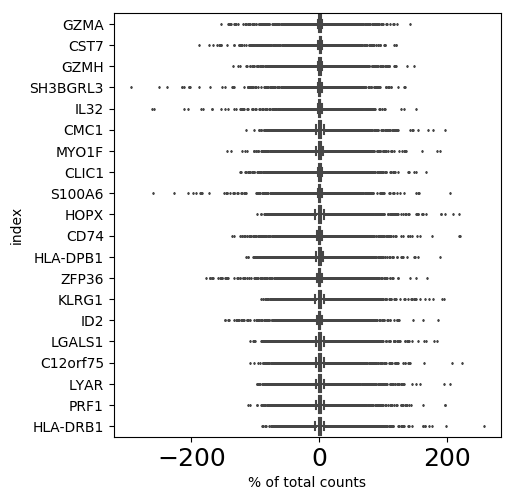

In [9]:
#---  Highly variable genes 

adata_Scrublet.var_names_make_unique()
sc.pl.highest_expr_genes(adata_Scrublet, n_top=20)

In [11]:
#--- filter cells with less then 400 genes
sc.pp.filter_cells(adata_Scrublet, min_genes=400) #***

#--- filter genes expressed in less then 3 cells
sc.pp.filter_genes(adata_Scrublet, min_cells=3)

filtered out 62264 cells that have less than 400 genes expressed
filtered out 123 genes that are detected in less than 3 cells


In [13]:
adata_Scrublet

AnnData object with n_obs × n_vars = 79 × 1079 
    obs: 'Samples', 'IDs', 'Batches', 'Groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
#--- Deal  with mitochondrial content 

mito_genes = adata_Scrublet.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata_Scrublet.obs['percent_mito'] = np.sum(
    adata_Scrublet[:, mito_genes].X, axis=1).A1 / np.sum(adata_Scrublet.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata_Scrublet.obs['n_counts'] = adata_Scrublet.X.sum(axis=1).A1


In [ ]:
#--- QC plots 

sc.pl.violin(adata_Scrublet, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
#--- number  of  genes plots 

sc.pl.scatter(adata_Scrublet, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_Scrublet, x='n_counts', y='n_genes')

In [ ]:
#-- filtering: number of genes and % mito

adata_Scrub = adata_Scrublet[adata_Scrublet.obs['n_genes'] < 2500, :]
adata_Scrub = adata_Scrublet[adata_Scrublet.obs['percent_mito'] < 0.2, :] #filter cell with more than 20% of mito genes

In [ ]:
#-- normalization 
sc.pp.normalize_per_cell(adata_Scrub, counts_per_cell_after=1e4)

#-Logarithmize the data.
sc.pp.log1p(adata_Scrub)

#-- highlu variable genes 
adata_Scrub.raw = adata_Scrub
sc.pp.highly_variable_genes(adata_Scrub, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_Scrub)

adata_Scrub = adata_Scrub[:, adata_Scrub.var['highly_variable']]

#--- regress out based on counts and % of mito 
sc.pp.regress_out(adata_Scrub, ['n_counts', 'percent_mito'])

#-- scale  the datat 
sc.pp.scale(adata_Scrub, max_value=10)



In [ ]:
#-- run PCA
sc.tl.pca(adata_Scrub, svd_solver='arpack')

#-- plot 
sc.pl.pca(adata_Scrub, color='CST3')

In [ ]:
# - plot PCs
sc.pl.pca_variance_ratio(adata_Scrub, log=True)

In [ ]:
adata_Scrub.write('./IL7R_Scrub_BC_090919.h5ad')
adata_Scrub

In [ ]:
#---- Computing the neighborhood graph
sc.pp.neighbors(adata_Scrub, n_neighbors=10, n_pcs=40) #***
sc.logging.print_memory_usage()


In [17]:
#----- run UMAP
sc.tl.umap(adata_Scrub, n_components=3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:11)


In [ ]:
#-- plot the scaled and corrected gene expression

from matplotlib import rcParams
rcParams['figure.figsize'] = (5,5)I 
sc.pl.umap(adata_Scrub, color=['GZMB', 'GZMA'], use_raw=False)

In [ ]:
#- Clustering the single-cell graph
sc.tl.louvain(adata_Scrub, resolution=1) #resolution=0.3

In [ ]:
rcParams['figure.figsize'] = (5,5)
sc.pl.umap(adata_Scrub, color=['IL7R', 'NKG7','louvain'], edgecolor='none', size=1, show=True, linewidths=10,legend_loc='on data')
sc.pl.umap(adata_Scrub, color=['IL7R', 'NKG7','louvain'], edgecolor='none', size=1, show=True, linewidths=10)

In [ ]:
#-------------------------------  BBKNN batch correction
import bbknn
#--- bbkkn batch correction --> 10X batches 
corrected = bbknn.bbknn(adata_Scrub, 
                        copy=True, 
                        batch_key="Batches", 
                        metric="angular", 
                        approx=True,
                        neighbors_within_batch=5, 
                        n_pcs=20, 
                        trim=50)


In [ ]:
#--- UMAP on corrected data 
sc.tl.umap(corrected, min_dist=0.3,n_components=3)

In [ ]:
#--- run louvain clustering on corrected data
sc.tl.louvain(corrected, resolution=1.2) #default , resolution = 1

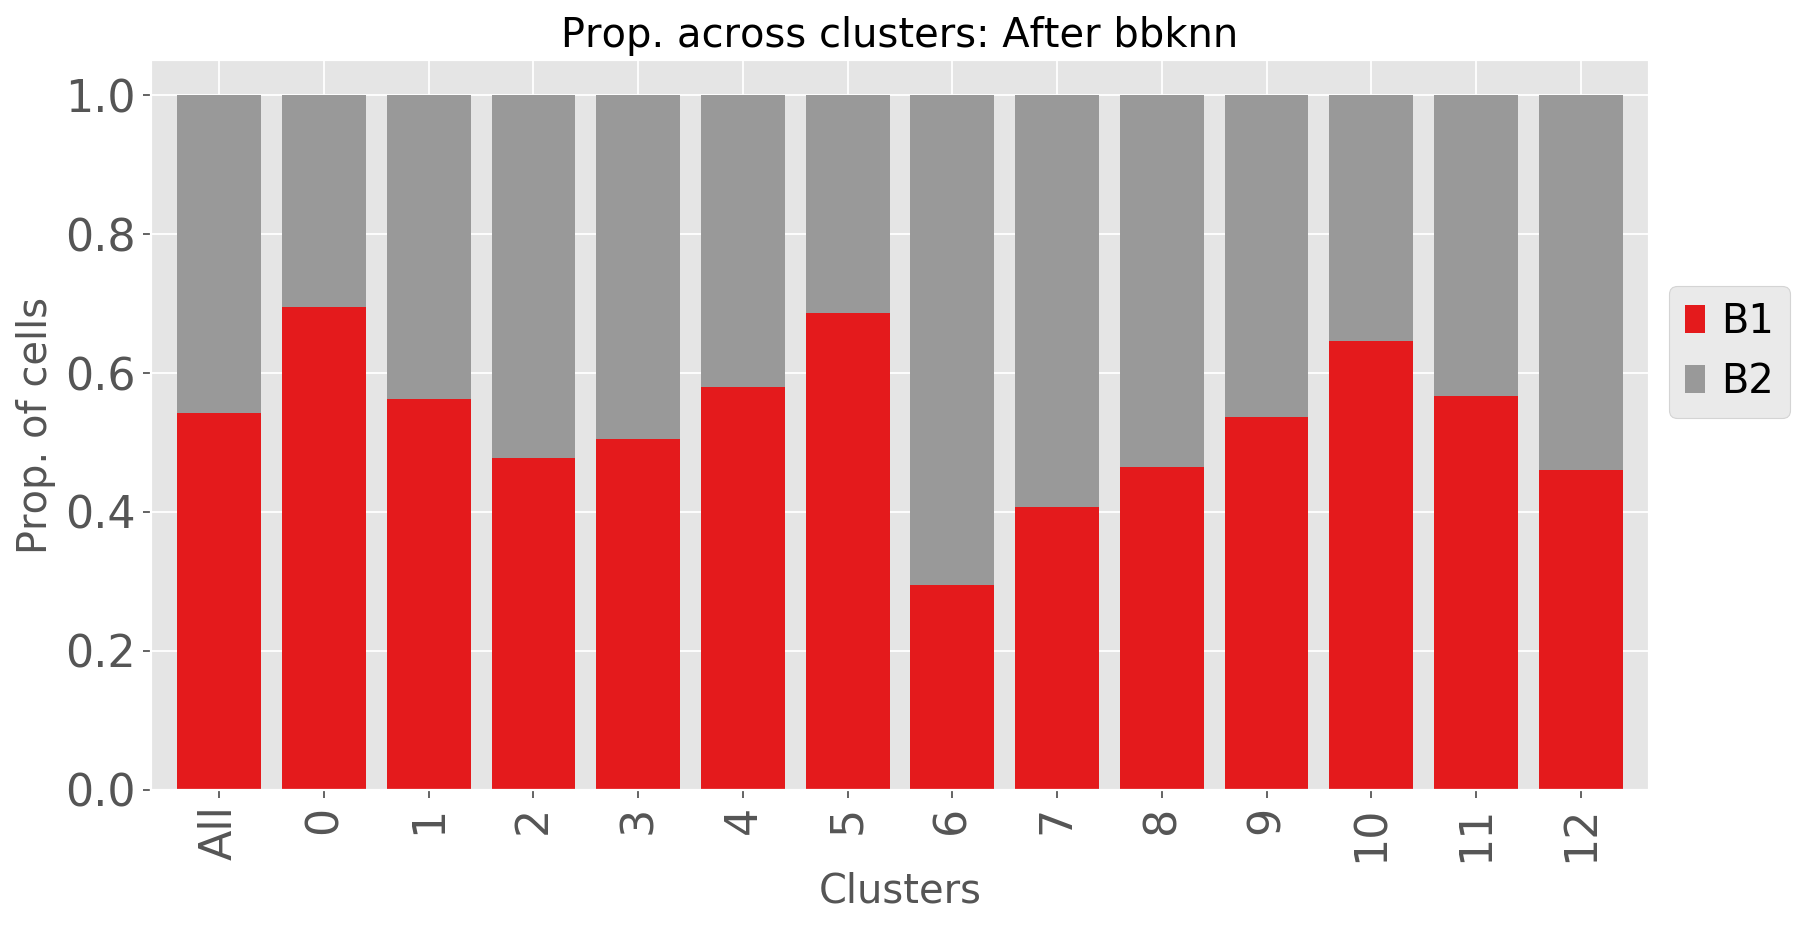

In [4]:
import pandas as pd

#-- proportion table
Groups_tab = pd.crosstab(index=corrected.obs['louvain'],  # Make a crosstab
                        columns=corrected.obs['Batches'], margins=True)               # Name the count column

col_ids =['#e41a1c','#999999','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#f781bf','#7fcdbb','#cab2d6',"#060404","#c994c7","#addd8e","#dd1c77","#fed976","#fdae6b","#7a0177","#08519c","#7a0177","#a6761d","#756bb1","#fdc086","#fb8072","#8dd3c7","#ece2f0","#a6bddb","#1c9099","#ae017e"]

#-- change index and columns order
Groups_tab = Groups_tab.reindex(['All','0','1','2','3','4','5','6','7','8','9','10','11','12'])
#Groups_tab = Groups_tab[['SLE','HD','All']]

MyTab= Groups_tab.div(Groups_tab["All"], axis=0)
MyTab2 = MyTab.drop(columns="All")


import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')   
#colors
#Col_Batches =['#e41a1c','#999999', '#377eb8','#4daf4a','#984ea3','#ff7f00',
 #          '#a65628']


MyTab2.plot(kind="bar",
            figsize=(12,6),
            stacked=True, 
            linewidth=1, 
            width=0.8, fontsize=20, color=col_ids)
plt.title("Prop. across clusters: After bbknn", fontsize=18)
plt.ylabel("Prop. of cells", fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.ylim=1.0

#plt.axhline(y=0.414570, color='B', linestyle='-')

#plt.gca().get_legend().remove() #remove legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.6), fontsize=18)
plt.show()

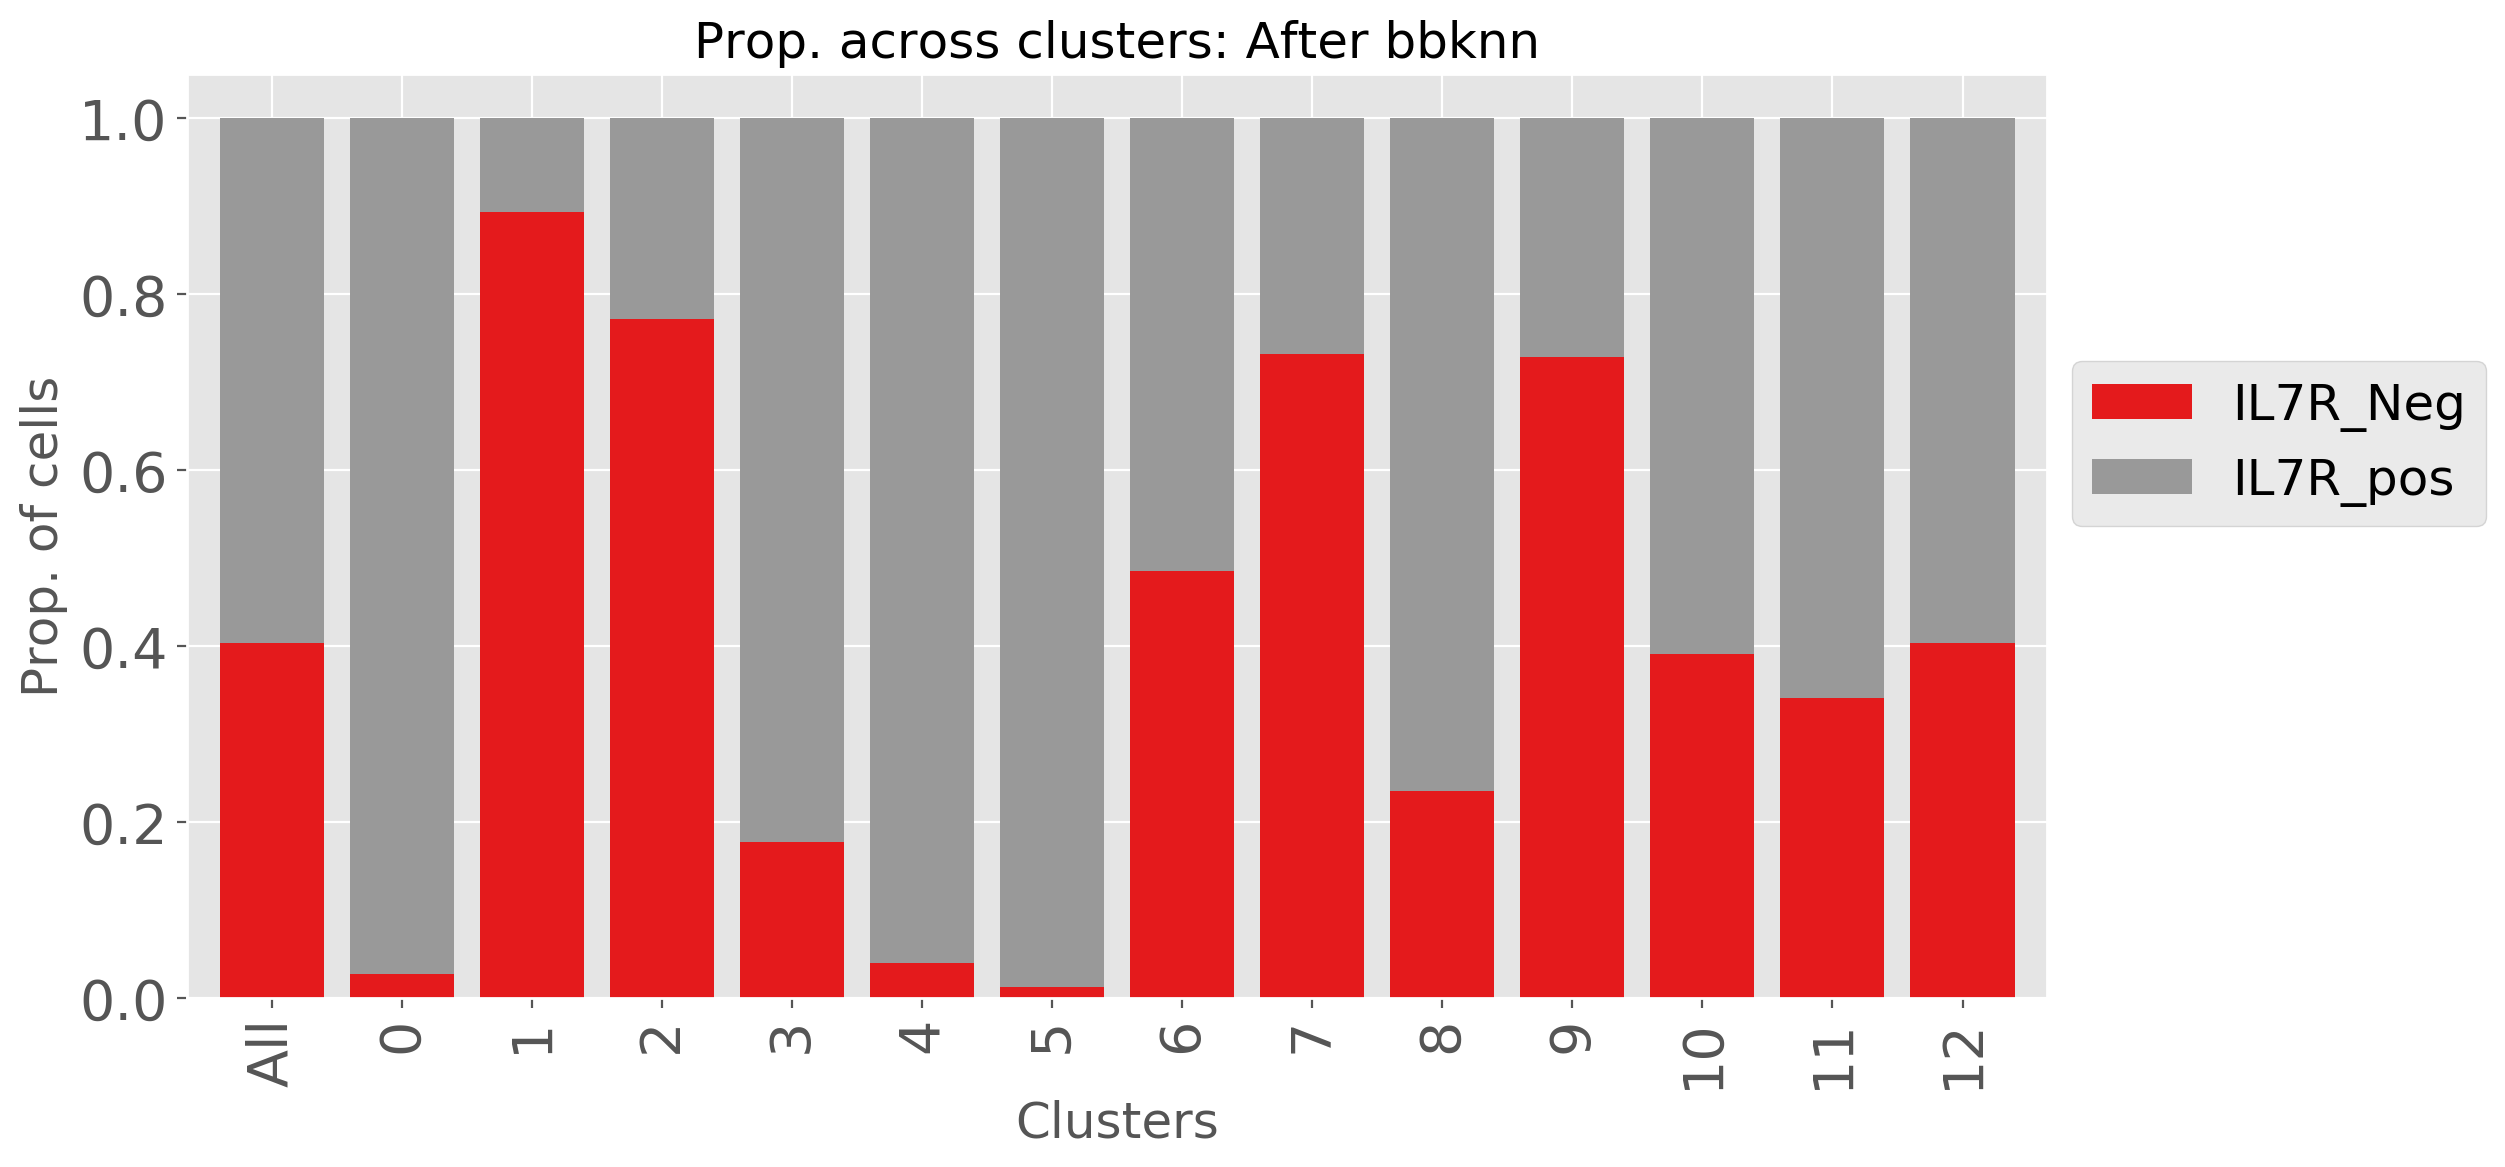

In [97]:
import pandas as pd

#-- proportion table
Groups_tab = pd.crosstab(index=corrected.obs['louvain'],  # Make a crosstab
                        columns=corrected.obs['Groups'], margins=True)               # Name the count column

col_ids =['#e41a1c','#999999','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#f781bf','#7fcdbb','#cab2d6',"#060404","#c994c7","#addd8e","#dd1c77","#fed976","#fdae6b","#7a0177","#08519c","#7a0177","#a6761d","#756bb1","#fdc086","#fb8072","#8dd3c7","#ece2f0","#a6bddb","#1c9099","#ae017e"]

#-- change index and columns order
Groups_tab = Groups_tab.reindex(['All','0','1','2','3','4','5','6','7','8','9','10','11','12'])
#Groups_tab = Groups_tab[['SLE','HD','All']]

MyTab= Groups_tab.div(Groups_tab["All"], axis=0)
MyTab2 = MyTab.drop(columns="All")


import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')   
#colors
#Col_Batches =['#e41a1c','#999999', '#377eb8','#4daf4a','#984ea3','#ff7f00',
 #          '#a65628']


MyTab2.plot(kind="bar",
            figsize=(12,6),
            stacked=True, 
            linewidth=1, 
            width=0.8, fontsize=20, color=col_ids)
plt.title("Prop. across clusters: After bbknn", fontsize=18)
plt.ylabel("Prop. of cells", fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.ylim=1.0

#plt.axhline(y=0.414570, color='B', linestyle='-')

#plt.gca().get_legend().remove() #remove legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.6), fontsize=18)
plt.show()

In [23]:
corrected.obs.louvain.value_counts()

0     9263
1     8390
2     8133
3     7131
4     6221
5     4121
6     4003
7     3674
8     3624
9     3337
10    2122
11    1409
12     915
Name: louvain, dtype: int64

In [8]:
#--- save embeddings AFTER CORRECTION

#--- Umap embbedings 
Emb = corrected.obsm.to_df()[['X_umap1', 'X_umap2', 'X_umap3']]
Emb.index = corrected.obs.index

#-- Meta Data 
meta = corrected.obs
Mat = meta.join(Emb)

Mat.to_csv('./Meta/IL7R_MetaEmb_AC.csv')


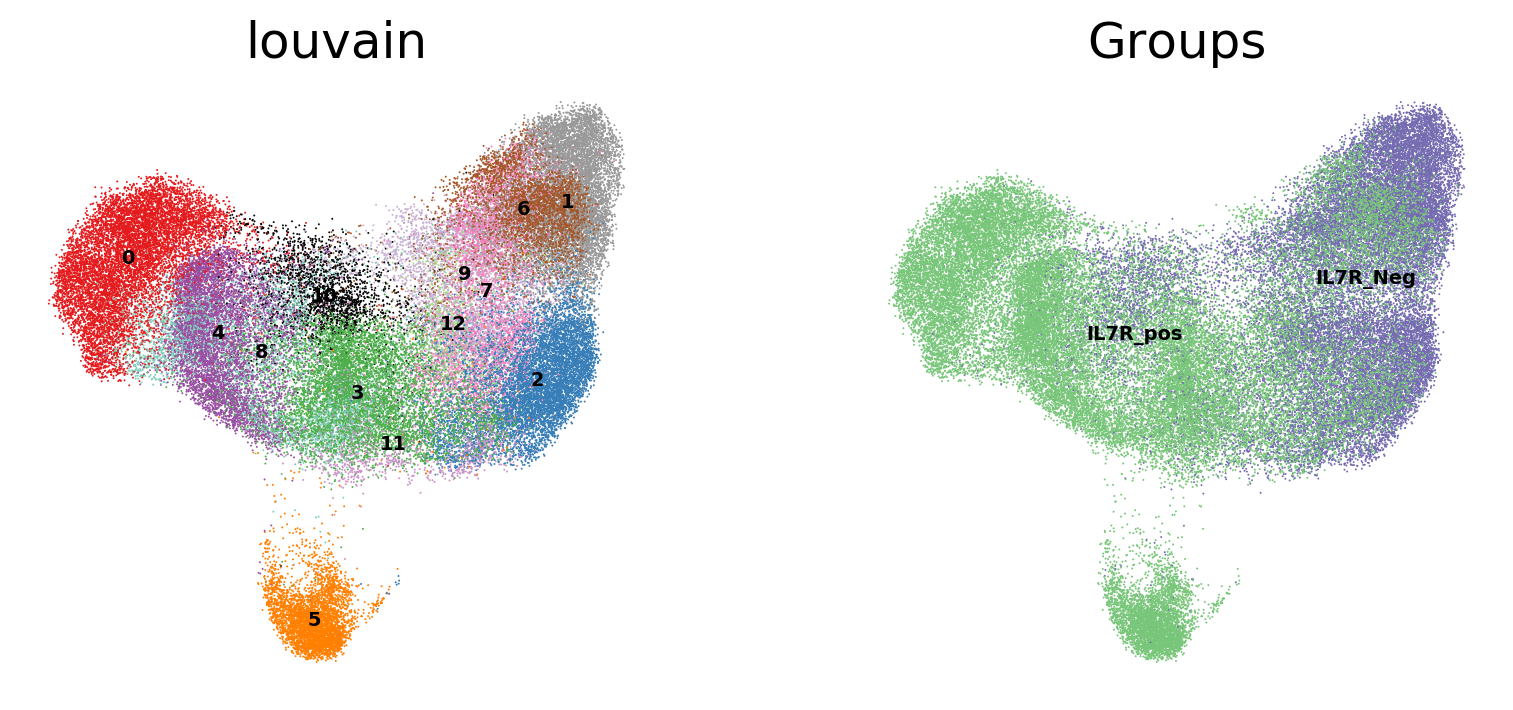

In [23]:
matplotlib.style.use('default')  

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize

rcParams['figure.figsize'] = (4,4)
genes=['clusters']

sc.pl.umap(corrected, 
           color=['louvain','Groups'],
           size=2, 
           color_map='OrRd',
           ncols=4,frameon=False,
           #legend_loc='on data', 
           legend_fontsize=7,legend_loc='on data') #, save='_YO_clusters.pdf'


In [6]:
#------------------------  Temra vs. naive  

cells_of_interest=corrected.obs.loc[corrected.obs["louvain"].isin(['0','4','8',
                                                                   '1','2','6']), :].index
C_AA = corrected[cells_of_interest, :]
C_AA


View of AnnData object with n_obs × n_vars = 39634 × 1202 
    obs: 'Samples', 'IDs', 'Batches', 'Groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'clusters'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batches_colors', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [7]:
#-- runing Louvain
sc.tl.louvain(C_AA, resolution=0.8) #default , resolution = 1

#-- runing UMAP
sc.tl.umap(C_AA, min_dist=0.3, n_components=3)



running Louvain clustering


Trying to set attribute `.obs` of view, making a copy.


    using the "louvain" package of Traag (2017)
    finished (0:00:05.43) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:44.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [27]:
#C_AA.write('./H5AD/Naive_vs_Eff_ForAkbar.h5ad') #'C0','4','8','1','2','6'

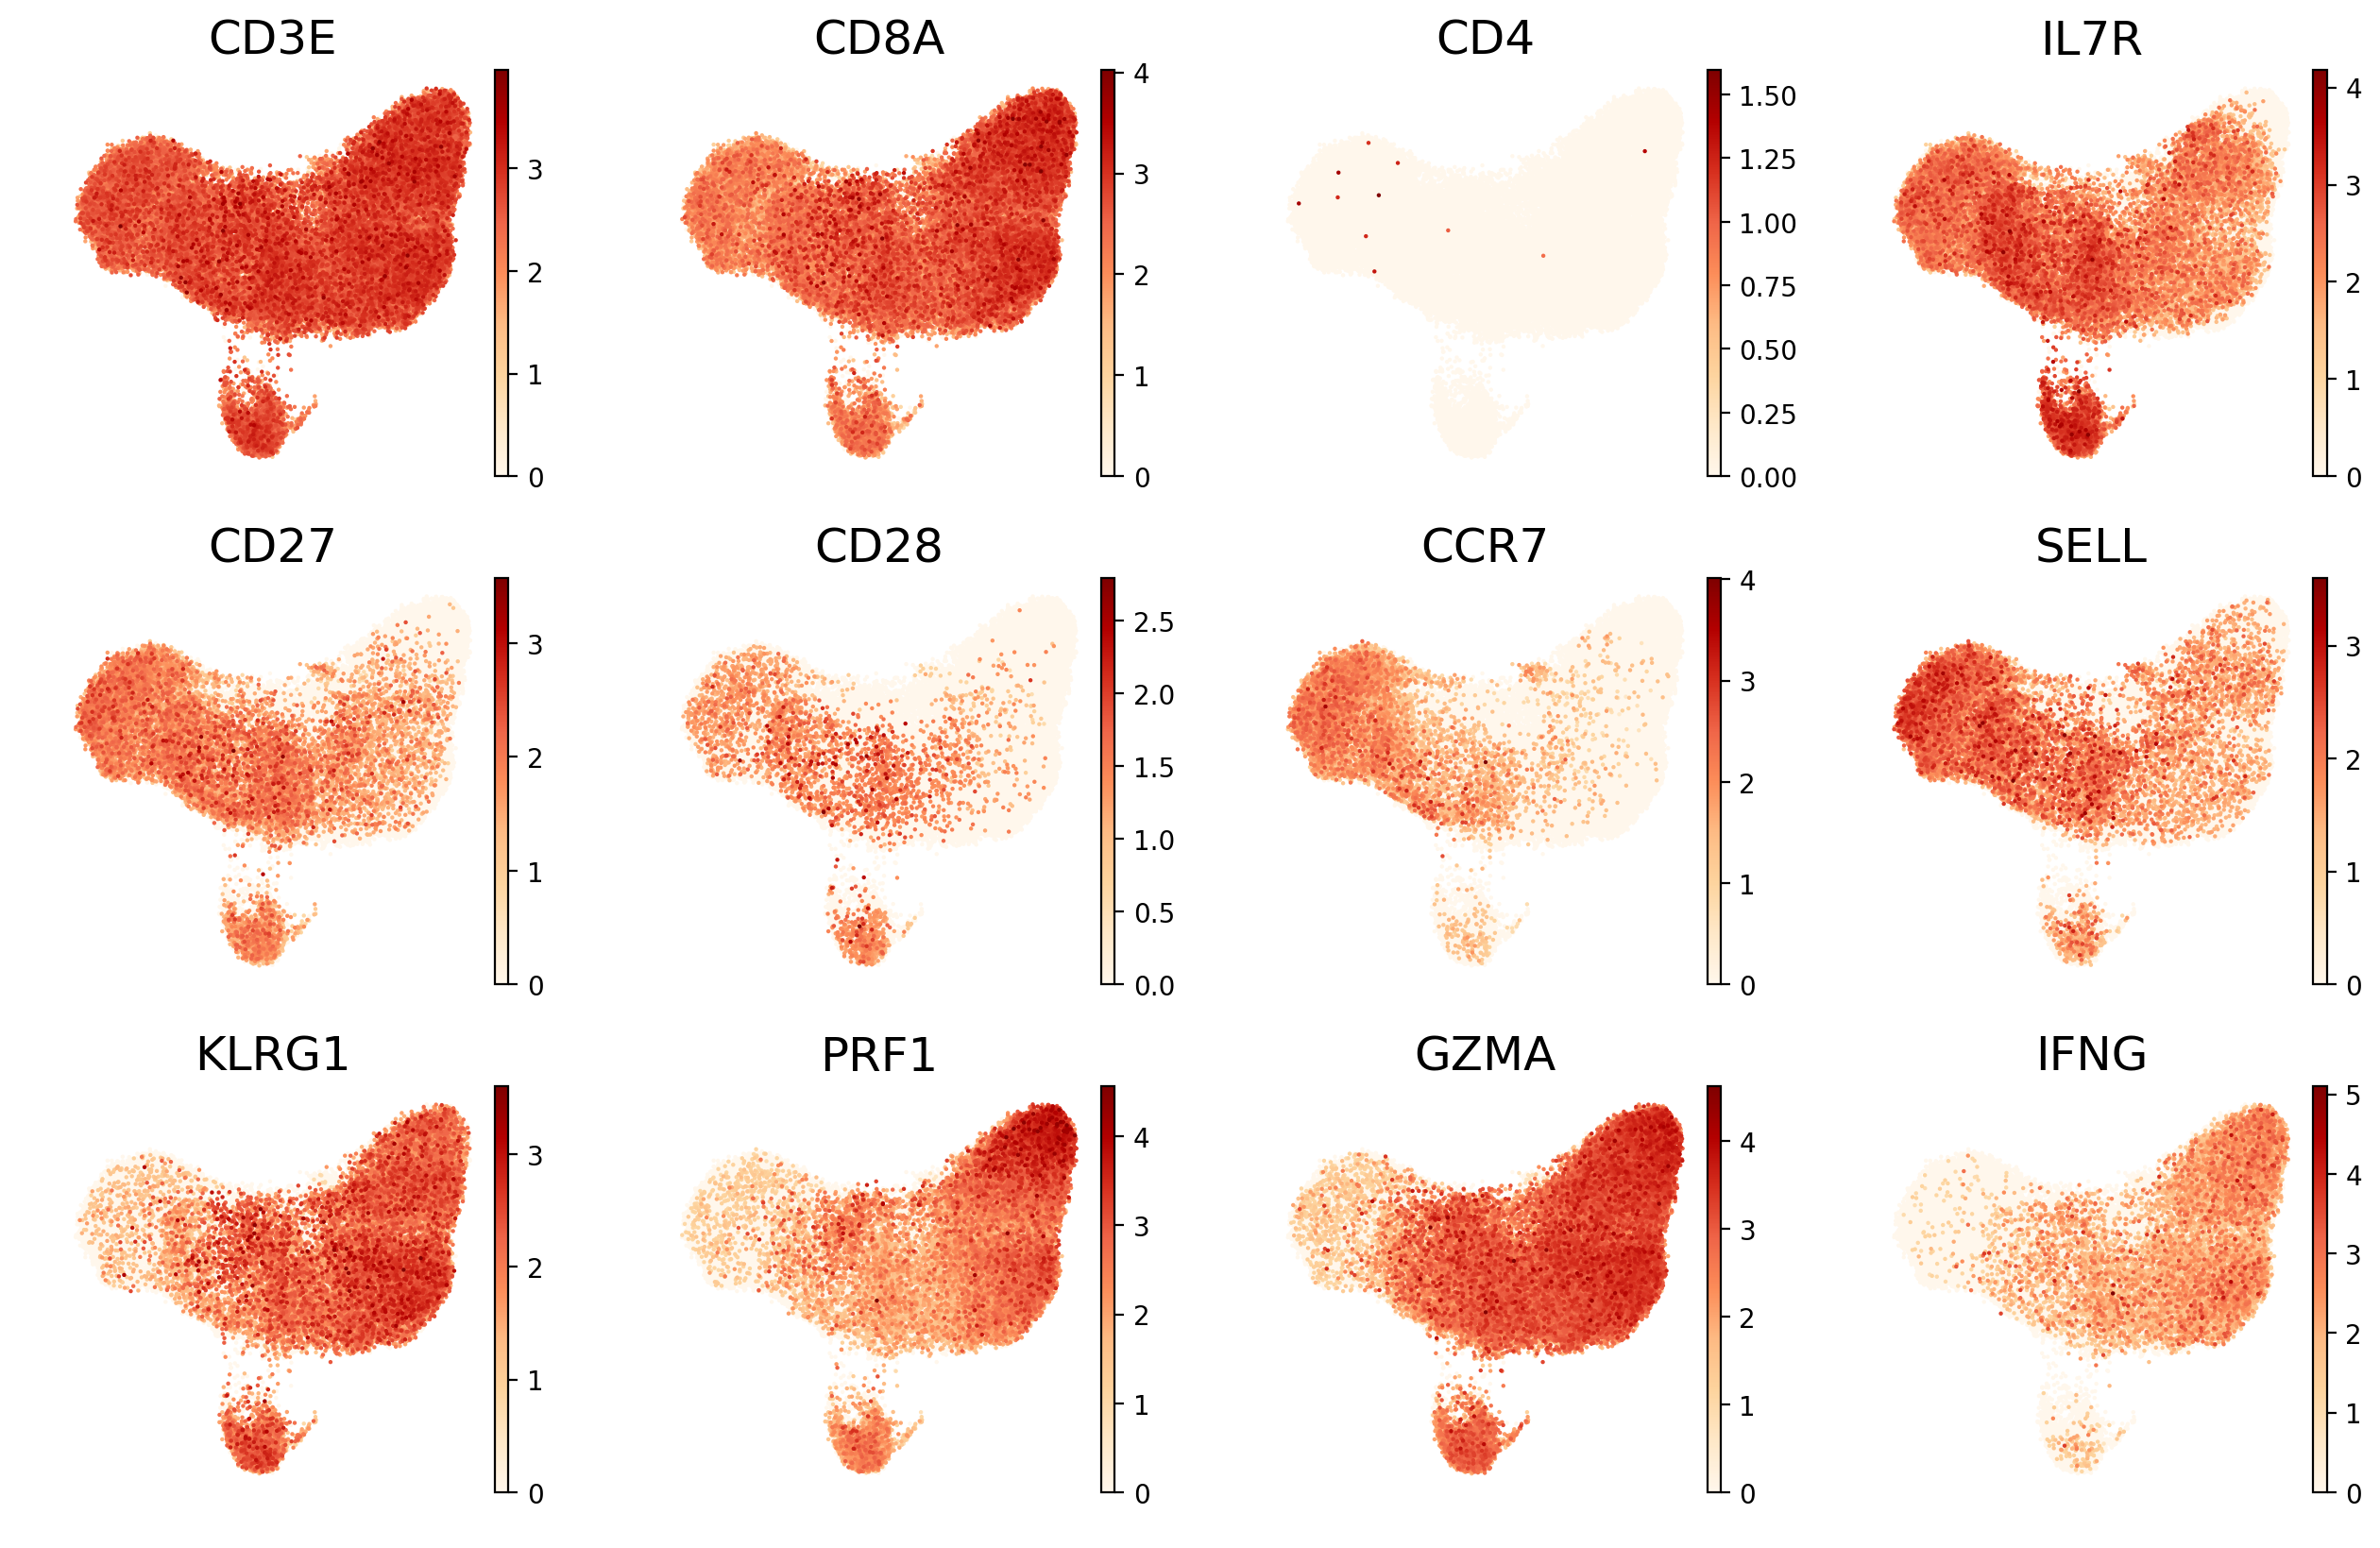

In [49]:
matplotlib.style.use('default')  
rcParams['figure.figsize'] = (3,3)


plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick 
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


sc.pl.umap(corrected, 
           color=genes,
           color_map='OrRd', 
           size=10, 
           ncols=4,  
           frameon=False, save='_IL7R_Fig.1d.pdf')


In [7]:
#--- NK scoring 

NK_genes = pd.read_csv('./Meta/NK_genes.csv', index_col=0)
NK_genes.head(5)

NK_ge = NK_genes.index
NK_ge

Index(['NKG7', 'GNLY', 'FCGR3A', 'FCRL6', 'KLRD1', 'KLRB1', 'KLRG1', 'TYROBP',
       'KLRK1', 'KLRC1', 'KLRC2', 'KLRF1', 'HCST', 'NCAM1', 'KIR2DL1'],
      dtype='object', name='genes')

In [13]:

C_AA.obs['NK_scores'] = C_AA[:,NK_ge].X.mean(1)
C_AA


AnnData object with n_obs × n_vars = 39634 × 1202 
    obs: 'Samples', 'IDs', 'Batches', 'Groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'clusters', 'Senesence', 'clusters_1', 'NK_scores'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batches_colors', 'Groups_colors', 'clusters_colors', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

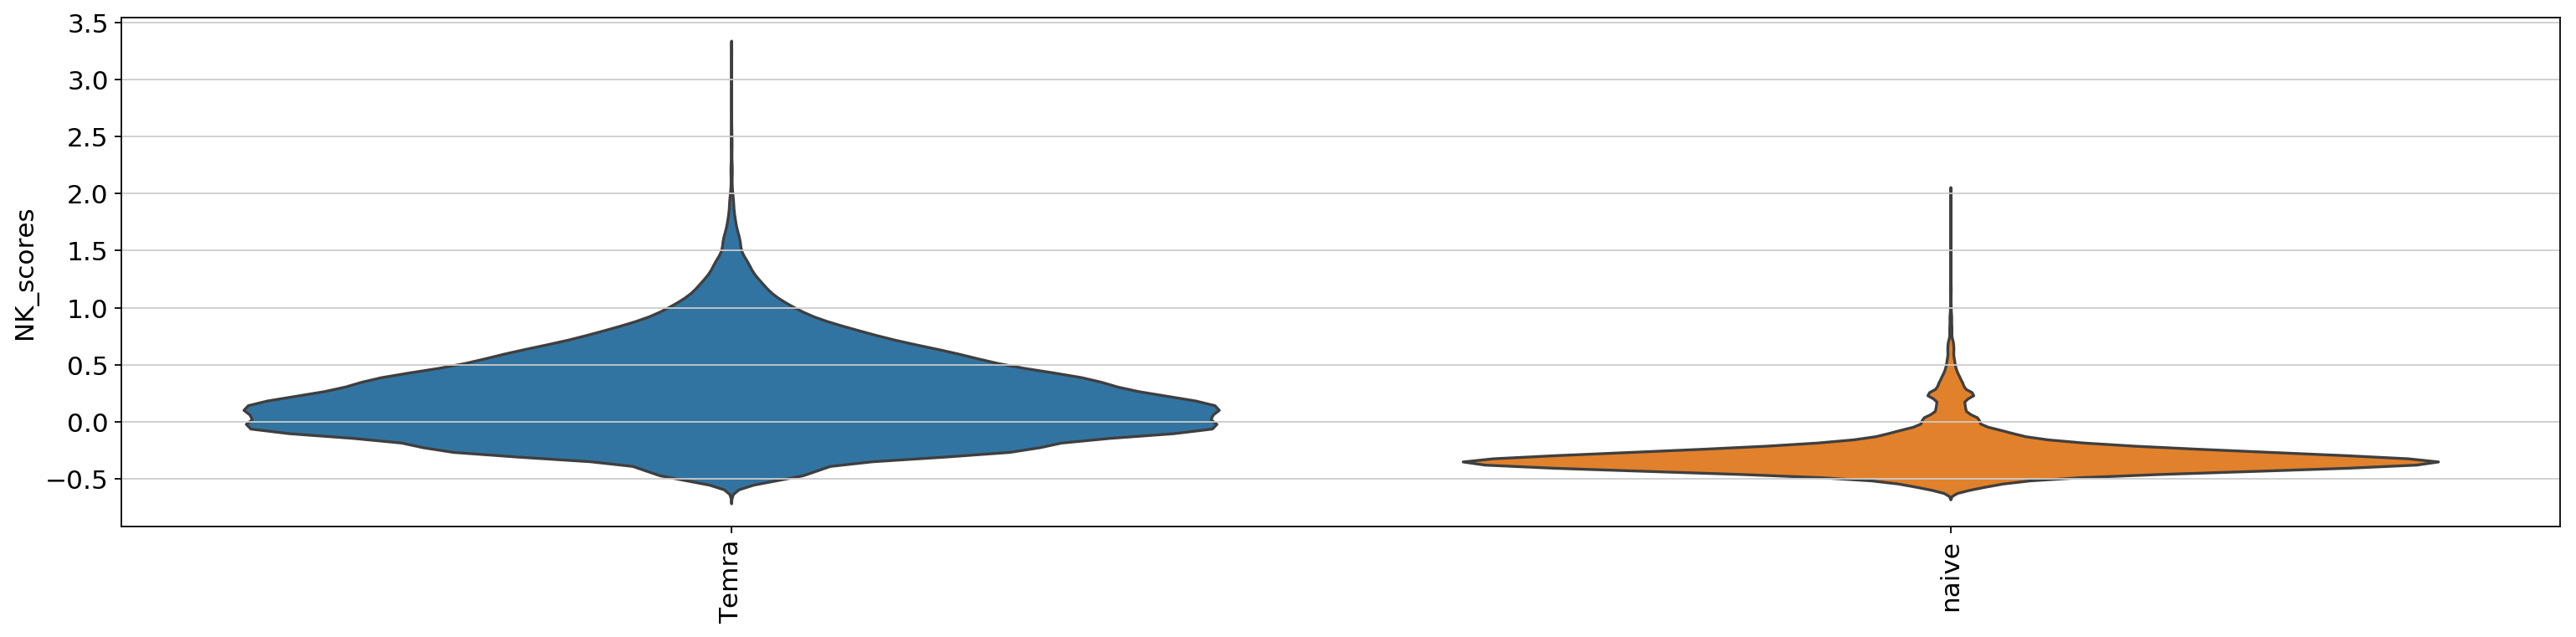

In [14]:

#-------- clusters 

rcParams['figure.figsize'] = (18,5)
sc.pl.violin(C_AA, 'NK_scores', groupby='clusters_1', rotation=90, size=0)


In [18]:
#-- save metaData 
C_AA.obs.to_csv('./Meta/C_AA_MetaEmb_100319.csv')
